In [26]:
%matplotlib notebook

from matplotlib import rcParams
# Set the font of the plots:
rcParams['font.family'] = 'Helvetica'
rcParams['font.sans-serif'] = ['Helvetica']
import matplotlib.pyplot as plt
import networkx as nx
import toverboom
import toverboom.lineageGraph
import toverboom.optimizeLayout
import toverboom.preprocessing
import pandas as pd

# Development:
import importlib
importlib.reload(toverboom)
importlib.reload(toverboom.lineageGraph)
importlib.reload(toverboom.preprocessing)
importlib.reload(toverboom.optimizeLayout)

<module 'toverboom.optimizeLayout' from 'j:\\hubrecht\\internaltools\\toverboom\\toverboom\\optimizeLayout.py'>

In [27]:
# Load the graph file into a networkx graph
graph = nx.read_graphml(f'../data/APKS1_CNV_tree.graphml')
graph = toverboom.preprocessing.convertFromStringKeys(graph)

<IPython.core.display.Javascript object>


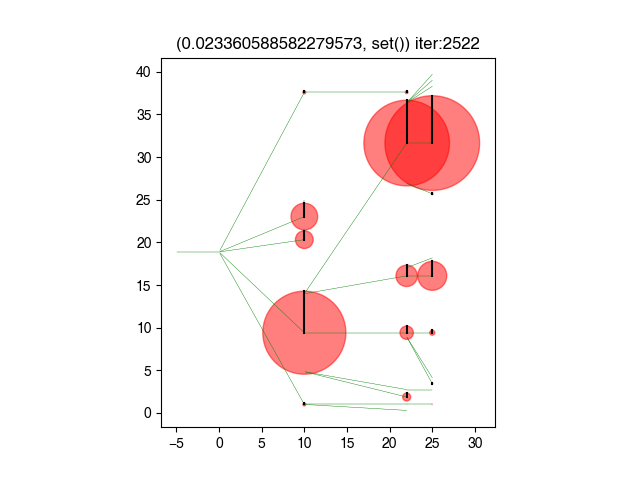

[35, 8, 30, 17, 9, 36, 2, 5, 24, 0, 4, 1, 19, 20, 3, 12, 34, 29, 23]

In [28]:
# Instantiate the lineage graph object
lg = toverboom.lineageGraph.LineageGraph(graph)

# Create a figure for our plot:
fig, ax = plt.subplots()

# Find the best layout
toverboom.optimizeLayout.optimize_layout(lg,visualize_progress_ax=ax, visualize_progress_fig=fig)

<IPython.core.display.Javascript object>


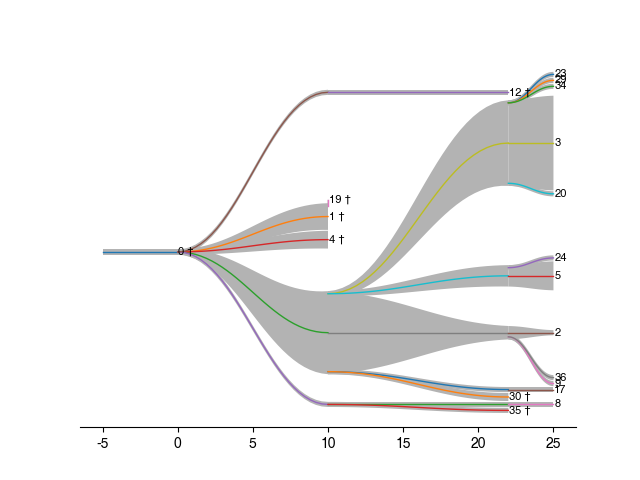

In [29]:
# Plot the polygons of the tree
fig, ax = plt.subplots()

# wavyness controls how wavy the segments of the tree are 
wavyness=0.4
# xDistance controls the stretch in the x direction 
lg.xDistance=10
lg.verticalSpacing = 0.1

lg.plotEdges(ax, bezier=True,wavyness=wavyness,stepCount=30,plotArgs={'lw':1}, offsetCentroid=True)
lg.plotPatches(ax=ax,wavyness=wavyness)

# Remove plot spines:
toverboom.lineageGraph.despine(ax)
# Scale labels to plot size:
toverboom.lineageGraph.format_x_axis_labels(ax)

# Add labels to the clones:
lg.annotateNodes(ax,plotArgs={'size':8})

fig.canvas.draw()

## Plot single cells on top of the tree

First construct a matrix where the single cells are described
Required columns are:
```
tp : timepoint where the cell was measured
cluster: to what cluster/clone does the cell belong
```
Optional columns are:
```
size : plotted size of the cell
marker : marker 
color  : color of the marker
```

In [30]:
# Load example data:
replicate = 'APKS1'
cellBarcodes = pd.read_pickle('../data/cellToBarcode.pickle').loc[replicate]
cellCnv = pd.read_pickle('../data/singleCellCNVClustering.pickle.gz').loc[replicate]
cellData = cellCnv

#### Contruct a dataframe with cell data

# Assign colors:
cellData['color'] = [{
    3:'r', 16:'r', 20:'r' ,
    5:'c',  21:'c',
    2:'orange'}.get(cluster,'grey') for cluster in cellData['cluster'] ]

# Assign passage:
cellData['tp'] = [passage for passage, plate, cell in list(cellData.index)]

# Assign sizes
cellData['size'] = [40 if cluster==2 else 20 for cluster in cellData['cluster'] ]

# Assign markers
cellData['marker'] = [{3:'+', 5:'+', 1:'*'}.get(cluster,'.') for cluster in cellData['cluster'] ]

cellData.head()

cluster   color  tp  size marker
10 1-1 6         1    grey  10    20      *
       62        8    grey  10    20      .
       68        2  orange  10    40      .
       83        2  orange  10    40      .
       88        2  orange  10    40      .

<IPython.core.display.Javascript object>


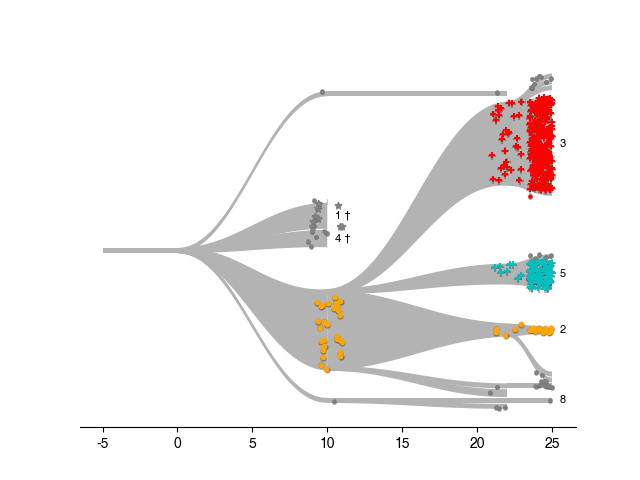

In [39]:
lg.plotSingleCells(cellData,plotPatches=True,enableShadow=True)
ax = plt.gca()
# Add labels to the clones:
lg.annotateNodes(ax,plotArgs={'size':8}, 
                 # Use the nodesToAnnotate argument to select which nodes to annotate
                 nodesToAnnotate=[
                     (cluster,tp)
                      for cluster,tp in lg.graph if cluster in [1,4,3,5,2,8]],
                 x_offset = 5 # How much to move the labels to the right
                )

## Color the tree patches

First construct a dataframe where the patches are described
The patches are EDGES of your graph, they are defined by 4 values:
starting clone, starting timepoint
ending clone, ending timepoint

```
fromTp : timepoint 
fromCluster: cluster
toTp : timepoint 
toCluster: cluster
```

All valid matplotlib colors can be used such as: 
``` 'green','r',(1,0,0), (1,0,0,0.5)``` 

To obtain which edges you can color run this command:
``` list(lg.graph.edges())```

In [32]:
patchColors =  pd.DataFrame(
    {
        ((2, 10), (3, 22)):{'color':'red','edgecolor':'k','lw':2},
        ((2, 10), (5, 22)):{'color':(0,0.5,0) }
    
    }).T
patchColors

color edgecolor   lw
(2, 10) (3, 22)          red         k    2
        (5, 22)  (0, 0.5, 0)       NaN  NaN

<IPython.core.display.Javascript object>


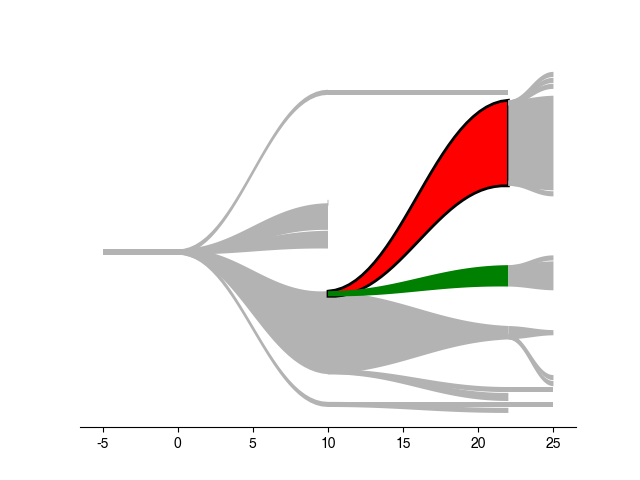

In [33]:
fig,ax = plt.subplots()
# Make plot scale the right way by plotting invisible edges:
lg.plotEdges(ax,plotArgs={'lw':0})

#Plot the patches using the matrix we just made
lg.plotPatches(ax,patchData=patchColors)

# Remove plot spines:
toverboom.lineageGraph.despine(ax)
# Scale labels to plot size:
toverboom.lineageGraph.format_x_axis_labels(ax)

fig.canvas.draw()